# 目的
あるクラウドファンディングが成功するか(state)を事前に予測するモデルを構築する。

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler # 標準化
from sklearn.model_selection import train_test_split

# データの読み込み

## データの扱いについて
| Variables | 変数 | 使う? | 変数の扱い |
| ---- | ---- | ---- |  ---- |
| ID | internal kickstarter id | - | - |
| name | プロジェクト名 | - | - |
| category | カテゴリー | ○ | ダミー変数 |
| main_category | category of campaign | ○ | ダミー変数 |
| currency | 通貨 | ○ | ダミー変数 |
| deadline | 期限 | ○ (開始日 - 期限 の募集機関で使ってみる) | 数値(日数) |
| goal | 目標金額 | ○ | 数値(金額) |
| launched | 開始日 | ○ (開始日 - 期限 の募集機関で使ってみる) | 数値(日数) |
| pledged | 集まった金額 | - (開始時にはわからないので使わない) | - |
| state | 成否 | ※目的変数 | fiailled: 0, successful: 1, Other: 捨てる(Pandasで) |

↓CSVデータを読み込み、データの整形を行う。

In [2]:
#ks_projects_data = pd.read_csv("ks-projects-201801.csv")[['category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'state']]

# 全データを読み込む
ks_projects_data = pd.read_csv("ks-projects-201801.csv")
display(ks_projects_data.head())
ks_projects_data.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [56]:
#欠損値確認
#ks_projects_data.info()
#ks_projects_data.isnull().sum()

# currency と country の対応を確認
#print(ks_projects_data['currency'].value_counts())
#print(ks_projects_data['country'].value_counts())
# ほぼ同じ情報を持っているので、使うのは currency だけにする。

In [3]:
# state が failed と successful 以外の行を削除 
# SettingWithCopyWarningがでるので copy() する
# indexが連番じゃなくなるので reset_index() で連番に直す
ks_projects_data2 = ks_projects_data[(ks_projects_data['state'] == 'failed') | (ks_projects_data['state'] == 'successful')].copy().reset_index(drop=True)

# 欠損値の確認
ks_projects_data2.isnull().sum()

# name と usd_pledged に欠損値があるが、usd_pledged は今回使わないので補完は行わない。
# name は今のところ使わない予定だが、使う場合はそのタイミングで補完を行う。

ID                    0
name                  3
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         210
usd_pledged_real      0
usd_goal_real         0
dtype: int64

In [4]:
# deadline - launched で募集期間を算出する
# pd.to_datetime() を使って、str を datetime64型に変換
# 日数(int)で出したいので、Series.dt() を使って変換
ks_projects_data2['launched'] = pd.to_datetime(ks_projects_data2['launched'], format='%Y-%m-%d %H:%M:%S')
ks_projects_data2['deadline'] = pd.to_datetime(ks_projects_data2['deadline'], format='%Y-%m-%d %H:%M:%S')
ks_projects_data2['duration'] = (ks_projects_data2['deadline'] - ks_projects_data2['launched']).dt.days
display(ks_projects_data2.head())
#print(type(ks_projects_data2.loc[0,'state']))
#display(ks_projects_data2['state'].value_counts())
#display(ks_projects_data2['currency'].value_counts())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,29
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00,34


In [5]:
# state を succesful = 1, failed = 0 に置換する
ks_projects_data2 = ks_projects_data2.replace({'state': {'failed': 0, 'successful': 1}})
display(ks_projects_data2.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,GB,0.0,0.0,1533.95,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,US,100.0,2421.0,30000.00,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,US,220.0,220.0,45000.00,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,US,1.0,1.0,5000.00,29
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,1,224,US,52375.0,52375.0,50000.00,34


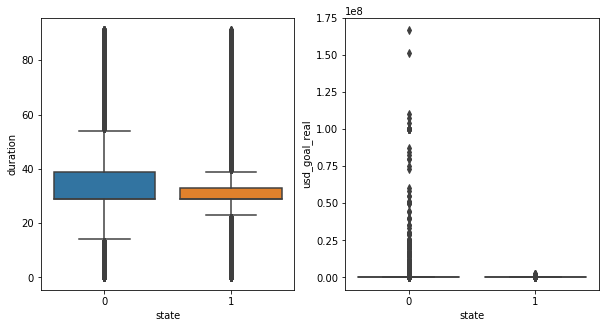

In [6]:
# グラフを書いてデータを確認する。
fig,ax = plt.subplots(1,2, figsize=(10,5))
sns.boxplot("state", "duration", data=ks_projects_data2, ax=ax[0])
sns.boxplot("state","usd_goal_real", data=ks_projects_data2, ax=ax[1]) 

# 募集期間は外れ値が多いが、成功は20~40ぐらいに分布しており、失敗は15~55ぐらいに分布している。
# 分布の幅が異なるので説明変数として使えそう。

# 目標金額が大きいものは失敗が多い。
# 目標金額が小さくても失敗しているものはあるので、目標金額だけで分類はできない。
# 目標金額が大きくなると失敗する傾向があるので、説明変数として使えそう。



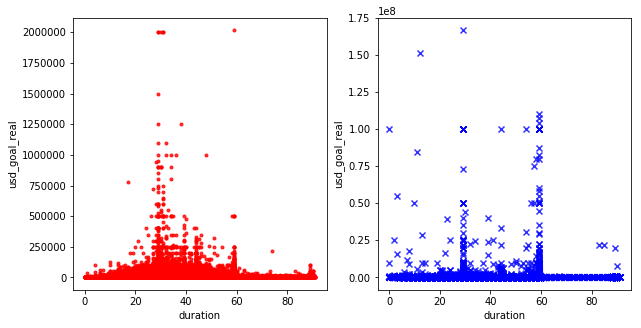

In [60]:
# 成功と失敗で DataFrameを分ける
ks_projects_data_successful = ks_projects_data2[(ks_projects_data2['state'] == 1)].copy().reset_index(drop=True)
ks_projects_data_failed = ks_projects_data2[(ks_projects_data2['state'] == 0)].copy().reset_index(drop=True)

# durationとusd_goal_readlの
fig2,ax2 = plt.subplots(1,2, figsize=(10,5))
sns.regplot('duration', 'usd_goal_real', data=ks_projects_data_successful, marker='.', color='red', ax=ax2[0])
sns.regplot('duration', 'usd_goal_real', data=ks_projects_data_failed, marker='x', color='blue', ax=ax2[1])



In [7]:
# durationとusd_goal_realの相関係数を計算
correlation = ks_projects_data2['duration'].corr(ks_projects_data2['usd_goal_real'])
print(correlation)

# durationとusd_goal_realは相関が無い

0.021606743271627128


## 学習に使うデータを準備

In [41]:
# 説明変数として使用する列だけ抽出
ks_projects_data3 = ks_projects_data2[['state', 'main_category', 'currency', 'usd_goal_real', 'duration']]

# main_category と currency をダミー変数にする
ks_projects_data3 = pd.get_dummies(ks_projects_data3, columns=['main_category', 'currency'])
display(ks_projects_data3.head())

# 学習用データとテストデータに分ける
# ホールドアウト法を使う
X = ks_projects_data3.drop('state', axis=1).values
y = ks_projects_data3['state'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

# usd_goal_real と duration を標準化する
stdsc = StandardScaler()
X_train_stand[:,0] = stdsc.fit_transform(X_train[:,0].reshape(-1,1)).reshape(1,-1)
X_test_stand[:,0] = stdsc.transform(X_test[:,0].reshape(-1,1)).reshape(1,-1)

X_train_stand[:,1] = stdsc.fit_transform(X_train[:,1].reshape(-1,1)).reshape(1,-1)
X_test_stand[:,1] = stdsc.transform(X_test[:,1].reshape(-1,1)).reshape(1,-1)


,state,usd_goal_real,duration,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,1533.95,58,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,30000.00,59,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,45000.00,44,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,5000.00,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,50000.00,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [48]:
# 学習用データを使ってロジスティック回帰モデルで学習する
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X_train_stand, y_train)

# 重みを取得して表示
w0 = clf.intercept_[0]
print("w0 = {:.3f}".format(w0))

wn = []
for i in range(len(clf.coef_[0])):
    wn.append(clf.coef_[0,i])
    print("w{} = {:.3f}".format(i+1, wn[i]))



w0 = -0.867
w1 = -17.345
w2 = -0.213
w3 = 0.017
w4 = 0.637
w5 = -0.822
w6 = 0.893
w7 = 0.072
w8 = -0.593
w9 = 0.039
w10 = -0.535
w11 = 0.194
w12 = -0.813
w13 = 0.413
w14 = -0.380
w15 = -0.293
w16 = -0.546
w17 = 0.848
w18 = -0.241
w19 = -0.107
w20 = -0.214
w21 = 0.060
w22 = -0.372
w23 = 0.127
w24 = 0.574
w25 = 0.513
w26 = -0.571
w27 = -0.467
w28 = -0.121
w29 = -0.262
w30 = 0.132
w31 = 0.083


In [61]:
# 学習用データに対する予測を実行
y_pred_train = clf.predict(X_train_stand)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_train)))

# 正答率を表示
print('正答率(Accuracy) = {:.3f}%'.format(100 * accuracy_score(y_train, y_pred_train)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score,_ = precision_recall_fscore_support(y_train, y_pred_train)

print('適合率(Precision) = {:.3f}%'.format(100 * precision[1]))
print('再現率(Recall) = {:.3f}%'.format(100 * recall[1]))
print('F1値(F1-score) = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_train, y_pred_train),
                        index = ['正解 = 失敗', '正解 = 成功'],
                        columns = ['予測 = 失敗', '予測 = 成功'])

display(conf_mat)


対数尤度 = -12.240
正答率(Accuracy) = 64.562%
適合率(Precision) = 59.970%
再現率(Recall) = 37.386%
F1値(F1-score) = 46.058%


,予測 = 失敗,予測 = 成功
正解 = 失敗,114770,23447
正解 = 成功,58829,35126


## Day1との比較
| - | Day1 | Day2 |
| --- | --- | --- |
| 対数尤度 | -13.885 | -12.240 | 
| 正答(Accuracy) | 59.799% | 64.562% |
| 適合率(Precision) | 56.161% | 59.970% |
| 再現率(Recall) | 2.110% | 37.386% |
| F1値(F1-score) | 4.067% | 46.058% |

説明変数を標準化することでDay1より予測精度が上がっている。

In [63]:
# テストデータに対する予測を実行
y_pred_test = clf.predict(X_test_stand)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred_test)))

# 正答率を表示
print('正答率(Accuracy) = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred_test)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score,_ = precision_recall_fscore_support(y_test, y_pred_test)

print('適合率(Precision) = {:.3f}%'.format(100 * precision[1]))
print('再現率(Recall) = {:.3f}%'.format(100 * recall[1]))
print('F1値(F1-score) = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_train, y_pred_train),
                        index = ['正解 = 失敗', '正解 = 成功'],
                        columns = ['予測 = 失敗', '予測 = 成功'])

display(conf_mat)


対数尤度 = -12.170
正答率(Accuracy) = 64.766%
適合率(Precision) = 60.003%
再現率(Recall) = 37.054%
F1値(F1-score) = 45.815%


,予測 = 失敗,予測 = 成功
正解 = 失敗,114770,23447
正解 = 成功,58829,35126


## 学習データとテストデータの比較
| - | 学習データ | テストデータ |
| --- | --- | --- |
| 対数尤度 | -12.240 | -12.170 | 
| 正答(Accuracy) | 64.562% | 64.766% |
| 適合率(Precision) | 59.970% | 60.003% |
| 再現率(Recall) | 37.386% | 37.054% |
| F1値(F1-score) | 46.058% | 45.815% |

ほとんど同じ値なので、過学習はしていない。